# Data exploration, cleaning and manipulation

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
albums = pd.read_csv('albums.csv', index_col=0, parse_dates=True)[1:]
albums['date'] = pd.to_datetime(albums.date)
print(albums.shape)
albums.head(3)

(573946, 7)


,id,date,artist,album,rank,length,track_length
index,,,,,,,
1,2,2019-01-19,A Boogie Wit da Hoodie,Hoodie SZN,1.0,20.0,185233.800000
2,3,2019-01-19,21 Savage,I Am > I Was,2.0,15.0,211050.733333
3,4,2019-01-19,Soundtrack,Spider-Man: Into The Spider-Verse,3.0,13.0,190866.384615


In order to capture the essence of an album's popularity, we'll create a popularity score based on the number of weeks an album was in the top 200 and the rank it had each week. 

In [3]:
from sklearn.preprocessing import MinMaxScaler

def popularity_score(albums, log=False, sqrt=False):
    # Make rank 1 worth 200 points and rank 200 worth 1 point (per week) 
    albums['rank'] = np.abs(albums['rank'] - 201)
    # Aggregating the score per album 
    popularity = albums.groupby(['album', 'artist'])['rank'].sum().sort_values(ascending=False)
    # Normalize potentially skewed score distribution with log or square root  
    if log:
        popularity = np.log(popularity)
    if sqrt:
        popularity = np.sqrt(popularity)
    # Scale popularity score to 0-10 for easier interpretability 
    scaler = MinMaxScaler(feature_range=(0,10)) 
    popularity = pd.DataFrame(scaler.fit_transform(popularity.values.reshape(-1,1)), index=popularity.index, columns=['popularity_score'])
    return popularity

For the future regression coefficients to be interpretable, the score should be distributed somewhat normally. Let's see which normalizing function leads to the best results!

Text(0, 0.5, 'frequency')

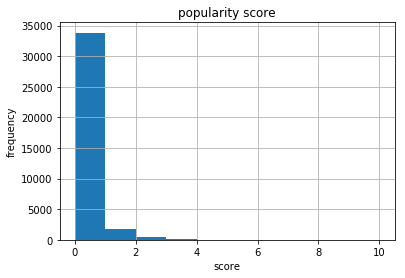

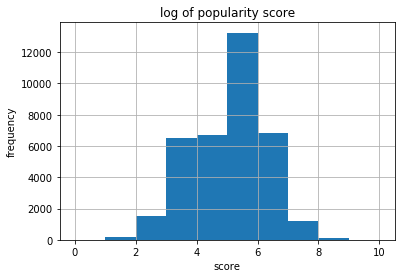

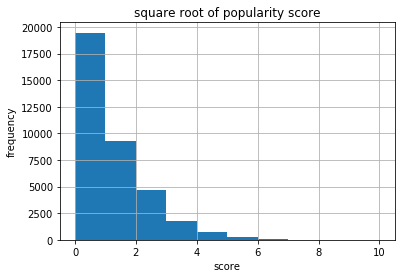

In [4]:
popularity_score(albums).hist()
plt.title('popularity score')
plt.xlabel('score')
plt.ylabel('frequency')
popularity_score(albums, log=True).hist()
plt.title('log of popularity score')
plt.xlabel('score')
plt.ylabel('frequency')
popularity_score(albums, sqrt=True).hist()
plt.title('square root of popularity score')
plt.xlabel('score')
plt.ylabel('frequency')

The histograms show that the log of popularity score is the closest to a normal distribution, so we'll take the log of our popularity score for our regression.

In [5]:
popularity = popularity_score(albums, log=True)

In [6]:
acoustic_features = pd.read_csv('acoustic_features.csv', index_col=0)
print(acoustic_features.shape)
acoustic_features.head(3)

(339855, 19)


,id,song,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,album_id,date
index,,,,,,,,,,,,,,,,,,,
0,0Veyvc3n9AcLSoK3r1dA12,Voices In My Head,Hoodie SZN,A Boogie Wit da Hoodie,0.0555,0.754,142301.0,0.663,0.000000,6.0,0.101,-6.311,0.0,0.427,90.195,4.0,0.207,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
1,77JzXZonNumWsuXKy9vr3U,Beasty,Hoodie SZN,A Boogie Wit da Hoodie,0.2920,0.860,152829.0,0.418,0.000000,7.0,0.106,-9.061,0.0,0.158,126.023,4.0,0.374,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21
2,18yllZD0TdF7ykcREib8Z1,I Did It,Hoodie SZN,A Boogie Wit da Hoodie,0.1530,0.718,215305.0,0.454,0.000046,8.0,0.116,-9.012,1.0,0.127,89.483,4.0,0.196,3r5hf3Cj3EMh1C2saQ8jyt,2018-12-21


Cleaning acoustic features

In [7]:
# Remove tracks less than a minute long 
features = acoustic_features.loc[acoustic_features['duration_ms'] > 60000]
# Drop non numeric columns 
features.drop(columns=['id', 'song', 'album_id', 'date'], inplace=True)
# Extract total run time per album 
length = features.groupby(['album', 'artist'])['duration_ms'].sum()
# Set index to album  
features.set_index(['album', 'artist'], inplace=True)
# Set length name to weights for clarity in weighted mean calculation
length.name = 'weights'
features.head(3)

C:\Users\shaiyon\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


acousticness  danceability  duration_ms  \
album      artist                                                            
Hoodie SZN A Boogie Wit da Hoodie        0.0555         0.754     142301.0   
           A Boogie Wit da Hoodie        0.2920         0.860     152829.0   
           A Boogie Wit da Hoodie        0.1530         0.718     215305.0   

                                   energy  instrumentalness  key  liveness  \
album      artist                                                            
Hoodie SZN A Boogie Wit da Hoodie   0.663          0.000000  6.0     0.101   
           A Boogie Wit da Hoodie   0.418          0.000000  7.0     0.106   
           A Boogie Wit da Hoodie   0.454          0.000046  8.0     0.116   

                                   loudness  mode  speechiness    tempo  \
album      artist                                                         
Hoodie SZN A Boogie Wit da Hoodie    -6.311   0.0        0.427   90.195   
           A Boogie Wit da Hoodie    -9.061   0.0        0.158  126.023   
           A Boogie Wit da Hoodie    -9.012   1.0        0.127   89.483   

                                   time_signature  valence  
album      artist                                           
Hoodie SZN A Boogie Wit da Hoodie             4.0    0.207  
           A Boogie Wit da Hoodie             4.0    0.374  
           A Boogie Wit da Hoodie             4.0    0.196

Aggregating songs by album weighted by the percentage of the album they take up. 

In [8]:
features = features.join(length)
# Extract percentage of the album each song takes up 
features['weights'] = features['duration_ms'] / features['weights']
# Multiply weights by each column 
features = features.drop(['weights', 'duration_ms'], axis=1).mul(features['weights'], axis=0)
length.name = 'length'
# Sum up the weighted data, grouping by album. Then add album length. 
features = features.groupby(['album', 'artist']).sum().join(length)
features.head(3)

,,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,length
album,artist,,,,,,,,,,,,,
!!Going Places!!,Herb Alpert & The Tijuana Brass,0.504944,0.634360,0.497121,0.636872,5.469885,0.107299,-11.909669,0.578203,0.093018,115.741766,4.000000,0.636955,1786385.0
!Viva El Amor!,Pretenders,0.102661,0.507975,0.717777,0.002417,7.703102,0.165748,-5.041795,0.723996,0.037021,129.670102,3.850478,0.530391,2715761.0
!Viva La Cobra!,Cobra Starship,0.046689,0.586020,0.789629,0.000007,2.522854,0.242735,-5.825477,0.282722,0.071973,122.389089,3.701332,0.700530,2219053.0


Next, we'll center and scale the features to have a mean of 0 and unit variance to make future regression coefficients significantly more interpretable.

In [9]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
features = pd.DataFrame(ss.fit_transform(features), columns=features.columns, index=features.index)
features.head(3)

,,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,length
album,artist,,,,,,,,,,,,,
!!Going Places!!,Herb Alpert & The Tijuana Brass,0.906995,0.729465,-0.658618,2.933496,0.181743,-0.785637,-0.758761,-0.608828,0.096166,-0.374514,0.610703,0.802187,-0.830192
!Viva El Amor!,Pretenders,-0.746051,-0.261481,0.529187,-0.516598,1.935347,-0.381715,1.029967,0.092515,-0.497468,0.714096,-0.303436,0.170338,-0.248708
!Viva La Cobra!,Cobra Starship,-0.976051,0.350445,0.915969,-0.529705,-2.132375,0.150313,0.825858,-2.030254,-0.126942,0.145027,-1.215272,1.179136,-0.559484


In [10]:
reviews = pd.read_csv('reviews.csv').drop(['index','id','role'], axis=1)
reviews.set_index(['album', 'artist'], inplace=True)
reviews.rename(columns={'score':'review_score'}, inplace=True)
print(reviews.shape)
reviews.head(3)

(20873, 7)


,,genre,review_score,date,author,review,bnm,link
album,artist,,,,,,,
“…The Best Live Show of All Time” — NME EP,David Byrne,Rock,5.5,January 11 2019,Andy Beta,"Viva Brother, Terris, Mansun, the Twang, Joe L...",0,https://pitchfork.com/reviews/albums/david-byr...
Lost Lovesongs / Lostsongs Vol. 2,DJ Healer,Electronic,6.2,January 11 2019,Chal Ravens,"The Prince of Denmark—that is, the proper prin...",0,https://pitchfork.com/reviews/albums/dj-healer...
Roman Birds,Jorge Velez,Electronic,7.9,January 10 2019,Philip Sherburne,"Jorge Velez has long been prolific, but that’s...",0,https://pitchfork.com/reviews/albums/jorge-vel...


In [11]:
print(reviews['genre'].nunique())
reviews['genre'].unique()[0:15]

137


array(['Rock', 'Electronic', 'Rap', 'Experimental', 'Pop/R&B',
       'Folk/Country', nan, 'Metal', 'Rock,Pop/R&B', 'Jazz',
       'Rock,Experimental', 'Metal,Rock', 'Jazz,Experimental',
       'Experimental,Electronic', 'Folk/Country,Experimental'],
      dtype=object)

We want to regress the data separately for each genre, but 137 is simply too many genres to deal with. So we'll use a regular expression to simplify the strings in the genre column to be only the first/primary genre. This puts the albums into broader, more easily digestable categories.

In [12]:
reviews['genre'] = reviews['genre'].replace(r'(,|/)[\w\W]+', '', regex=True)
print(reviews['genre'].nunique())
reviews['genre'].unique()

9


array(['Rock', 'Electronic', 'Rap', 'Experimental', 'Pop', 'Folk', nan,
       'Metal', 'Jazz', 'Global'], dtype=object)

Now that the data is fully cleaned, it's time to join the features and scores, removing albums that don't have data in the process.

In [13]:
data = features.reset_index().join(reviews[['genre', 'review_score']], on=['album', 'artist']).set_index(['album', 'artist']).dropna()
data = data.reset_index().join(popularity, on=['album', 'artist']).set_index(['album', 'artist']).fillna(0)
print(data.shape)
data.head(20)

(1761, 16)


,,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,length,genre,review_score,popularity_score
album,artist,,,,,,,,,,,,,,,,
$O$,Die Antwoord,-0.714888,1.609190,0.489080,-0.140446,-0.457791,-0.280548,0.535534,-0.761014,1.537186,0.315966,1.459717,0.166186,0.076382,Rap,5.5,3.173876
...And Star Power,Foxygen,-0.334712,-1.440631,-0.054928,0.947206,-0.083812,0.425895,0.125685,1.017485,-0.230305,0.318942,-0.377202,-0.271276,1.122319,Rock,7.0,2.912184
...And Then You Shoot Your Cousin,The Roots,0.547939,0.574016,-0.510038,-0.350169,-0.335559,-0.667088,-0.686169,-1.928120,0.923312,-0.959039,0.610703,-0.789071,-0.718414,Rap,7.2,3.617485
1 Up Top Ahk,Mozzy,-0.469660,0.312573,-0.026530,-0.529743,-1.198396,-0.509585,0.234379,-1.280237,3.589599,-1.948609,0.319825,-0.712926,-0.105935,Rap,7.6,2.720763
"10,000 Days",Tool,-1.167645,0.539490,1.342451,4.633092,2.135869,-0.750124,0.173990,1.420245,0.169298,0.590916,0.610703,-1.720825,-1.373407,Metal,5.9,7.161339
1000 Palms,Surfer Blood,-0.592763,0.111054,0.987280,1.429291,-0.251584,-0.445571,0.768075,0.945999,-0.376785,0.654524,0.340397,0.909936,-0.523128,Rock,6.6,3.542467
12,A$AP Twelvyy,0.180124,0.777715,0.033089,-0.529685,0.569586,0.307837,0.415785,-0.997034,3.027357,0.205533,-0.033556,-0.989880,-0.529018,Rap,6.4,3.467600
12 Memories,Travis,-0.041608,-0.430804,-0.040311,0.499170,-0.947908,0.041217,0.165844,-1.222848,-0.531407,-0.030710,-1.054288,-0.690852,-0.288285,Rock,5.1,4.168276
12 Songs,Neil Diamond,1.922247,-0.010488,-1.546187,-0.527292,-0.470291,-0.649687,-0.522136,0.265544,-0.530835,-0.640772,0.076580,-0.785824,-0.073163,Rock,4.1,5.446497


# Linear Regression on acoustic features and review score

In [14]:
import statsmodels.api as sm

for genre in data['genre'].unique():
    genre_df = data.loc[data['genre'] == genre]
    X = genre_df.iloc[:,:13]
    y = genre_df['review_score']
    if len(X) > len(X.columns):
        ols = sm.OLS(y, X)
        res = ols.fit()
        print('\n'+format(genre))
        print(res.summary())


Rap
                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     224.4
Date:                Fri, 14 Jun 2019   Prob (F-statistic):          7.77e-161
Time:                        20:49:00   Log-Likelihood:                -817.17
No. Observations:                 363   AIC:                             1660.
Df Residuals:                     350   BIC:                             1711.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
acousticness        -1.4168      0.

# Linear Regression on acoustic features and popularity score

In [15]:
for genre in data['genre'].unique():
    genre_df = data.loc[data['genre'] == genre]
    X = genre_df.iloc[:,:13]
    y = genre_df['popularity_score']
    if len(X) > len(X.columns):
        ols = sm.OLS(y, X)
        res = ols.fit()
        print('\n'+format(genre))
        print(res.summary())


Rap
                            OLS Regression Results                            
Dep. Variable:       popularity_score   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     183.8
Date:                Fri, 14 Jun 2019   Prob (F-statistic):          1.60e-147
Time:                        20:49:00   Log-Likelihood:                -742.43
No. Observations:                 363   AIC:                             1511.
Df Residuals:                     350   BIC:                             1561.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
acousticness        -1.1026      0.


Experimental
                            OLS Regression Results                            
Dep. Variable:       popularity_score   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     6.130
Date:                Fri, 14 Jun 2019   Prob (F-statistic):           2.51e-05
Time:                        20:49:00   Log-Likelihood:                -86.859
No. Observations:                  42   AIC:                             199.7
Df Residuals:                      29   BIC:                             222.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
acousticness         1.296